# Machine Learning Classification Project - Stroke Dataset

**Student name**: Jordana Tepper, Troy Hendrickson, Viktoria Szontagh  
**Student pace**: Full Time  
**Instructor name**: Joseph Mata  

In [676]:
#Basics
import numpy as np
import pandas as pd
from IPython.display import Markdown, display

# Data visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from IPython.display import Image

%matplotlib inline

# Pre-Processing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import precision_score, recall_score, plot_confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE, SMOTENC

# Metrics
from sklearn.model_selection import cross_validate, ShuffleSplit
from sklearn.model_selection import KFold
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import KNNImputer
from sklearn import set_config
from sklearn.metrics import recall_score
set_config(display= 'diagram')

## Data Understanding

In [677]:
df = pd.read_csv('data/healthcare-dataset-stroke-data.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [678]:
# looking at the general information of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


There are 5110 rows and 12 columns in the dataset with variables of the following Datatypes: int, object, and float.

The categorical columns (Datatype 'object') 'gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'.

Despite 'hypertension', 'heart_disease', and 'stroke' being type 'int', we know that these are actually categorical columns, as well.

Furthermore, there appears to be missing values in the 'bmi' column.

In [679]:
# looking at basic metrics of the dataset (for the numerical columns)
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [680]:
# looking at basic metrics of the dataset (for the categorical columns)
df.describe(include='object')

,gender,ever_married,work_type,Residence_type,smoking_status
count,5110,5110,5110,5110,5110
unique,3,2,5,2,4
top,Female,Yes,Private,Urban,never smoked
freq,2994,3353,2925,2596,1892



Outliers:
* There are outliers in the age column with a minimum value of 0.08 - indicating that this dataset includes children.
* There are outliers in the 'avg_glucose_level' column with a maximum of 271.74
* There are outliers in the 'bmi' column with a maximum of 97.6

In [681]:
# further investigation of the missing values
df.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

Based on information above, there are 201 missing values in the 'bmi' column and no missing values in the other columns.

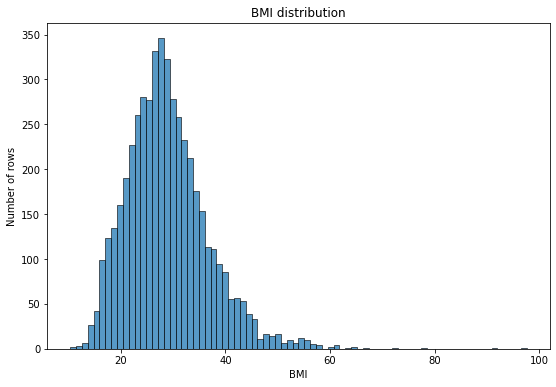

In [682]:
# distribution of the BMI column
fig ,ax = plt.subplots(figsize = (9,6))
sns.histplot(df['bmi'])
ax.set_title('BMI distribution')
ax.set_xlabel('BMI')
ax.set_ylabel('Number of rows')
plt.show()

The 'bmi' columns seems a little skewed to the right, so we will fill in the missing values with the median using Simple Imputer after we train_test_split.

In [683]:
# checking the distribution of gender
df['gender'].value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

There is only one line were the gender is 'other', so we will drop this row.

In [684]:
# checking the distribution of the hyperstension column
df['hypertension'].value_counts()

0    4612
1     498
Name: hypertension, dtype: int64

In [685]:
# checking the distribution of the heart disease column
df['heart_disease'].value_counts()

0    4834
1     276
Name: heart_disease, dtype: int64

In [686]:
# distribution of ever_married column
df['ever_married'].value_counts()

Yes    3353
No     1757
Name: ever_married, dtype: int64

In [687]:
# distribution of work_type
df['work_type'].value_counts()

Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64

In [688]:
# distribution of Residence_type
df['Residence_type'].value_counts()

Urban    2596
Rural    2514
Name: Residence_type, dtype: int64

In [689]:
df['smoking_status'].value_counts()

never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64

There are 1544 indices in the dataset where the smoking status is 'Unknown'. This need to be further investigated.

In [690]:
# checking the smoking status for 'unknown' and age below 13
df[(df['smoking_status'] == 'Unknown') & (df['age'] < 13)]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
162,69768,Female,1.32,0,0,No,children,Urban,70.37,NaN,Unknown,1
249,30669,Male,3.00,0,0,No,children,Rural,95.12,18.0,Unknown,0
251,16523,Female,8.00,0,0,No,Private,Urban,110.89,17.6,Unknown,0
282,33759,Female,3.00,0,0,No,children,Urban,73.74,16.0,Unknown,0
291,11014,Male,4.00,0,0,No,children,Rural,79.17,20.0,Unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...
5078,27446,Female,8.00,0,0,No,children,Urban,76.31,15.5,Unknown,0
5079,42709,Male,1.72,0,0,No,children,Urban,77.28,17.1,Unknown,0
5089,56714,Female,0.72,0,0,No,children,Rural,62.13,16.8,Unknown,0
5095,68598,Male,1.08,0,0,No,children,Rural,79.15,17.4,Unknown,0


Based on the global statistic for smoking in children, we will change the value in 'smoking_status' from 'Unknown' to 'never smoked' for those rows the where the age is below 13 years old.

In [691]:
# distribution of stroke
df['stroke'].value_counts()

0    4861
1     249
Name: stroke, dtype: int64

In most of the cases, 4861 indices, the patient had no history of a stroke. 

In 249 of the cases, the patient had a history of a stroke.


## Data Preparation

In [692]:
# dropping the id column as we will not be working with this column
df.drop('id', axis=1, inplace=True)

In [693]:
# dropping the row with gender 'other'
df.drop(df[df.gender == 'Other'].index, inplace = True)

In [694]:
# reclassify those who are under 13 as never smoker
df.loc[((df['smoking_status'] == 'Unknown') & (df['age'] < 13)), 'smoking_status'] = 'never smoked'

In [695]:
# checking to see if the code above worked
df['smoking_status'].value_counts()

never smoked       2439
Unknown             997
formerly smoked     884
smokes              789
Name: smoking_status, dtype: int64

Based on the values in the 'avg_glucose_level' column, we will assume that the glucose testing was done postprandial (after eating).

* A postprandial blood sugar level of less than 70 mg/dL indicates hypoglycemia.

* A postprandial blood sugar level of greater than or equal to 70 mg/dL and less than or equal to 140 mg/dL indicates normal glucose levels.

* A postprandial blood sugar level of greater than 140 mg/dL and less than or equal to 200 indicates pre-diabetes.

* A postprandial blood sugar level of greater than 200 indicates diabetes.

Below, we add a new column and categorize the data accordingly.

In [696]:
# adding new column to categorize the glucose level
df.loc[df['avg_glucose_level'] < 70, 'blood_sugar_cat'] = 'hypoglycemia'
df.loc[(df['avg_glucose_level'] >= 70) & (df['avg_glucose_level'] <= 140), 'blood_sugar_cat'] = 'normal'
df.loc[(df['avg_glucose_level'] > 140) & (df['avg_glucose_level'] <= 200), 'blood_sugar_cat'] = 'pre-diabetic'
df.loc[df['avg_glucose_level'] > 200, 'blood_sugar_cat'] = 'diabetic'

## Data Analysis

### Distribution of ages among those who have had a stroke

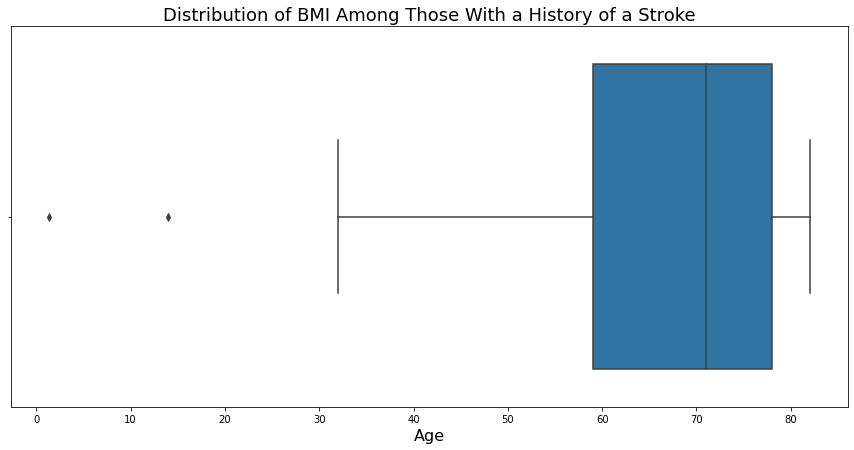

In [697]:
# Making a box plot to show the distributions of age for those who have had a stroke
stroke_yes = df.loc[df['stroke'] == 1]
fig, ax = plt.subplots(figsize = (15, 7))
fig = sns.boxplot(x=stroke_yes['age'])
ax.set_title('Distribution of BMI Among Those With a History of a Stroke', fontdict = { 'fontsize': 18});
ax.set_xlabel('Age', fontdict = { 'fontsize': 16});

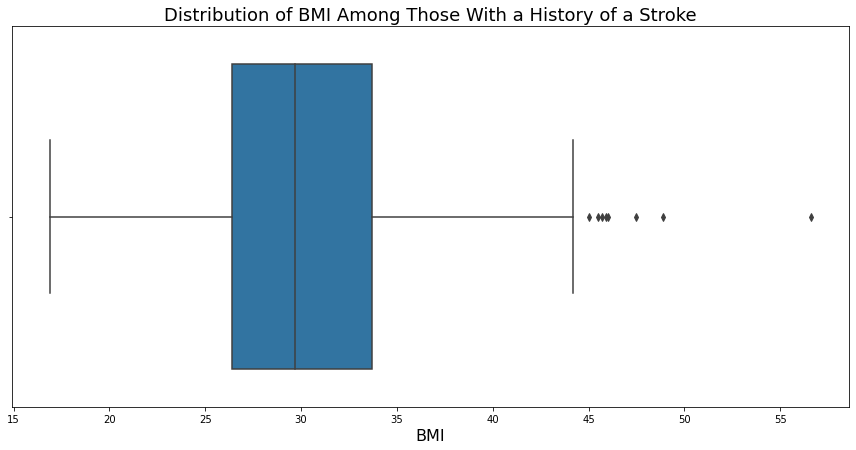

In [698]:
# Making a box plot to show the distributions of bmi for those who have had a stroke
fig, ax = plt.subplots(figsize = (15, 7))
fig = sns.boxplot(x=stroke_yes['bmi'])
ax.set_title('Distribution of BMI Among Those With a History of a Stroke', fontdict = { 'fontsize': 18});
ax.set_xlabel('BMI', fontdict = { 'fontsize': 16});

## Modeling

**Due to the fact that we are interested in detecting stroke risk, a false negative is more costly than a false positive.**

**Therefore, the metric that matters most in our project is recall.**

In [699]:
# train test split
X = df.drop(columns = 'stroke', axis = 1)
y = df['stroke']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.20, random_state = 42)

In [700]:
# Simple imputer for missing bmi values 
bmi_imp = SimpleImputer(missing_values=np.nan, strategy='median')
X_train['bmi'] = bmi_imp.fit_transform(X_train[['bmi']])
X_test['bmi'] = bmi_imp.transform(X_test[['bmi']])

In [701]:
# oheX_train = pd.get_dummies(X_train[ohelist])
# oheX_test =  pd.get_dummies(X_test[ohelist])



# X_train = pd.concat([X_train, oheX_train], 1)

# X_t


### Creating Column Transformer Pipeline

In [702]:
cat_list = ['gender', 'ever_married', 'work_type', 'Residence_type', 
            'smoking_status']

In [703]:
num_cols = ['age', 'bmi', 'avg_glucose_level']

In [704]:
# Define numeric pipeline with standard scaler
num_pipe = imbpipeline([('numnorm', StandardScaler())])

# Define categorical pipeline
cat_pipe = imbpipeline([('onehotenc', OneHotEncoder(sparse = False, drop = 'first')), 
                     ('onehotnorm', StandardScaler())])


ct = ColumnTransformer(transformers = 
    [("nominalpipe", cat_pipe, cat_list),
     ("numpipe", num_pipe, num_cols)])

### Model 1: Baseline Model (Logistic Regression)

In [708]:
baseline_pipeline = imbpipeline([('preprocess', ct),('smote', SMOTE()),
                              ('model', LogisticRegression())])

In [709]:
baseline_pipeline.fit(X_train, y_train)
baseline_pipeline.score(X_train,y_train)

0.7430878394910693

In [710]:
y_pred = baseline_pipeline.predict(X_test)

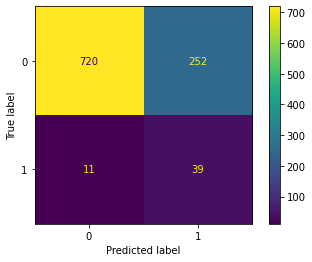

In [711]:
ConfusionMatrixDisplay.from_estimator(baseline_pipeline, X_test, y_test);

In [712]:
model_1_recall = recall_score(y_test, y_pred)
model_1_recall

0.78

### _Comments on Baseline Model_

These r